# NCAA Embeddings
> Learning complex features of NCAA teams with limited data types.

- toc: true 
- badges: true
- comments: true
- image: images/embeddings_preview.png
- categories: [kaggle]

![](https://raw.githubusercontent.com/rysarmstr/Data-Bites-Blog/master/images/embeddings_preview.png "Left: T-SNE team embeddings trained from win/loss and point differential data. Right: Raw data aggregated by team.")



## Introduction

I expected to compete in my first Kaggle competitions this March - both the NCAA [Men's](https://www.kaggle.com/c/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament) and [Women's](https://www.kaggle.com/c/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament) basketball tournaments. Unfortunately, both tournaments were cancelled due to the Covid-19 pandemic. Regardless, working through my different ideas was a great way to learn some of the basics and nuances of training an ML model effectively.

The typical successful model on Kaggle is an XGBoost ensemble model aimed at classifying wins and losses of tournament games. The biggest differences generally come down to feature selection and engineering. A key advantage of neural networks is the ability of a large network to learn non-linear relationships, which ultimately limit the necessity for complex feature engineering. However, training and test data is limited in this case. The most detailed data sets extend back to 2003, which gives ~1,140 games. Many of which have spurious results that the best models would not predict. As expected, a neural network architecture without feature engineering performs much more poorly on this data set; a network with feature engineering performs similarly to an XGBoost model. In future posts, I will explore more complex deep learning architectures such as RNNs for tournament prediction, but here I'll focus on feature engineering.

The easiest way to generate features for tournament prediction is to average a team's regular season statistics. The Kaggle data set contains various statistics, but users also commonly generate [advanced statistics](https://bleacherreport.com/articles/1813902-advanced-nba-stats-for-dummies-how-to-understand-the-new-hoops-math) before aggregation. The aggregated features are useful, but do not compensate for opponent strength. If a team had an easy schedule, it may have artificially higher statistics than another. Some methods like the [Bradley-Terry model](https://en.wikipedia.org/wiki/Bradley%E2%80%93Terry_model) (implemented in Python [here](https://pypi.org/project/choix/)), solve for single-value team strengths using previous comparisons of results across all teams. This implementation solves for team strengths based only on wins and losses and couldn't possibly distinguish between aspects of a teams strength. But what if we generalize this concept of pairwise-comparisons using [embeddings](https://en.wikipedia.org/wiki/Word_embedding)?

This notebook will generate team-level embeddings, representative of regular season data (win/losses, point differential, court location) that could be used to train a tournament model. A simple exploratory analysis suggests that the trained embeddings are a richer representation of the original feature data set that could be implemented in a tournament model. Future testing and expansion of this method to advanced statistics will be needed to confirm that!

**What you will see in this notebook:**
 - Brief data prep - we are only using wins/losses, points, home/away, and team IDs as inputs to the model. *Later, I will expand this model to advanced statistics*, but training the model on this subset of data allows us to test the concept all the way back to 1985!
 - Model build - This model is being built with the sole purpose of generating useful embeddings. To achieve that we are training the model to be predictive of features that we would ordinarily use as feature inputs to a real tournament model (in this case, regular season wins and losses).
 - Training and validation - the model is trained using only regular season data from all years and is validated on a secondary set of tournament data ([NIT](https://en.wikipedia.org/wiki/National_Invitation_Tournament)). This is difficult because we have a slight mismatch between our training and validation data. The validation data is generally similar and likely more representative of the real NCAA tournament. That is okay; the end goal of this model is trained embeddings and not win prediction.
 - Sense check and exploratory analysis - First thing is to check that predictions from the model are sensible, but what we really care about is the embeddings. Do they carry more useful information than simple aggregations of the data they represent? In short, Yes!

Note: This work was inspired by [this Kaggle notebook](https://www.kaggle.com/abhijitbrahme/embedding-ncaa-model), which is the first basketball application I've seen of this concept. Here is a second example of embeddings used for [baseball](https://www.youtube.com/watch?v=nQK44L9j9hY&list=UUk36k_W8ew3v2ZDjQgKi10Q&index=83) and the concept could easily be applied to other sports.

In [62]:
#collapse_hide
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
import keras as k
from keras.models import Model
from keras.layers import Dense, Input, Dropout, Activation, Multiply, Lambda, Concatenate, Subtract, Flatten
from keras.layers.embeddings import Embedding
from keras.initializers import glorot_uniform, glorot_normal
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.manifold import TSNE
import altair as alt
np.random.seed(13)

## Input data

Kaggle provides two regular season data sets: one with less detailed statistics dating back to 1985, and one with more detailed statistics dating back to 2003. For this proof of concept, I'll simplify the model by working with the older data set. The model will be trained on less powerful statistics, but we will have more historical context during data exploration. Let's preview the first few rows of the regular season data:

In [63]:
#collapse_hide
dataLoc=Path('./data/2020-05-04-NCAA-Embeddings/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage2/')

df_teams = pd.read_csv(dataLoc/'MTeams.csv')
teams_dict = df_teams[['TeamID','TeamName']].set_index('TeamID').to_dict()['TeamName']

df_regSeason_data = pd.read_csv(dataLoc/'MRegularSeasonCompactResults.csv')
df_regSeason_data.head() # cols = Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


Each game is listed only once with separate columns for winner and loser statistics. The data will be reformatted to leave us with the following inputs and outputs to the model:
 - Team IDs
 - Team locations (home or away)
 - Odds of 'Team A' winning (classification/logistic regression)
 - Expected point differential (team 1 - team 2, regression)

Each game is presented to the model twice, once as 'Team A vs. Team B' and vice versa. Team IDs also need to be reformatted to differentiate a single school's team by year (e.g. Duke 2019 $\neq$ Duke 2020). This may be an oversimplification, but is clearly a better assumption than treating the entire history of a school the same.

Finally, we want to use as much of the training data as possible to train them embeddings. Because the true accuracy of model is insignificant, secondary tournament data (NIT) is used as training validation. This provides a sense that the model is training correctly, but doesn't require sacrificing valuable regular season or NCAA tournament data in the process. This data set has the same format as the regular season data and is processed accordingly.

In [64]:
#collapse_hide
# load validation data
df_otherTourney_data = pd.read_csv(dataLoc/'MSecondaryTourneyCompactResults.csv').drop(columns='SecondaryTourney')

# Create team encoding that differentiates teams by year and school
def newTeamID(df):
    # df = df.sample(frac=1).reset_index(drop=True)
    df['Wnewid'] = df['Season'].astype(str) + df['WTeamID'].astype(str)
    df['Lnewid'] = df['Season'].astype(str) + df['LTeamID'].astype(str)
    return df

df_regSeason_data = newTeamID(df_regSeason_data)
df_otherTourney_data = newTeamID(df_otherTourney_data)

def idDicts(df):
    newid_W = list(df['Wnewid'].unique())
    newid_L = list(df['Lnewid'].unique())
    ids = list(set().union(newid_W,newid_L))
    ids.sort()
    oh_to_id = {}
    id_to_oh = {}
    for i in range(len(ids)):
        id_to_oh[ids[i]] = i 
        oh_to_id[i] = ids[i]

    return oh_to_id, id_to_oh

oh_to_id, id_to_oh = idDicts(df_regSeason_data)    

# add training data in swapped format so network sees both wins and losses
def swapConcat_data(df):

    df['Wnewid'] = df['Wnewid'].apply(lambda x: id_to_oh[x])
    df['Lnewid'] = df['Lnewid'].apply(lambda x: id_to_oh[x])

    loc_dict = {'A':-1,'N':0,'H':1}
    df['WLoc'] = df['WLoc'].apply(lambda x: loc_dict[x])

    swap_cols = ['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 'Lnewid', 'Wnewid']

    df_swap = df[swap_cols].copy()

    df_swap['WLoc'] = df_swap['WLoc']*-1

    df.columns = [x.replace('WLoc','T1_Court')
                   .replace('W','T1_')
                   .replace('L','T2_') for x in list(df.columns)]

    df_swap.columns = df.columns

    df = pd.concat([df,df_swap])

    df['Win'] = (df['T1_Score']>df['T2_Score']).astype(int)
    df['Close_Game']= abs(df['T1_Score']-df['T2_Score']) <3
    df['Score_diff'] = df['T1_Score'] - df['T2_Score']
    df['Score_diff'] = df['Score_diff'] - (df['Score_diff']/df['Score_diff'].abs())
    df['T2_Court'] = df['T1_Court']*-1
    df[['T1_Court','T2_Court']] = df[['T1_Court','T2_Court']] + 1

    cols = df.columns.to_list()

    df = df[cols].sort_index()
    df.reset_index(drop=True,inplace=True)


    return df

df_regSeason_full = swapConcat_data(df_regSeason_data.copy().sort_values(by='DayNum'))
df_otherTourney_full = swapConcat_data(df_otherTourney_data.copy())

# Convert to numpy arrays in correct format
def prep_inputs(df,id_to_oh, col_outputs):
    Xteams = np.stack([df['T1_newid'].values,df['T2_newid'].values]).T
    Xloc = np.stack([df['T1_Court'].values,df['T2_Court'].values]).T

    if len(col_outputs) <2:
        Y_outputs = df[col_outputs].values
        Y_outputs = Y_outputs.reshape(len(Y_outputs),1)
    else:
        Y_outputs = np.stack([df[x].values for x in col_outputs])

    return [Xteams, Xloc], Y_outputs

X_train, Y_train = prep_inputs(df_regSeason_full, id_to_oh, ['Win','Score_diff'])
X_test, Y_test = prep_inputs(df_otherTourney_full, id_to_oh, ['Win','Score_diff'])

# Normalize point outputs - Win/loss unchanged
def normalize_outputs(Y_outputs, stats_cache=None):
    if stats_cache == None:
        stats_cache = {}
        stats_cache['mean'] = np.mean(Y_outputs,axis=1)
        stats_cache['var'] = np.var(Y_outputs,axis=1)
    else: pass
    
    numOut = Y_outputs.shape[0]
    Y_normout = (Y_outputs-stats_cache['mean'].reshape((numOut,1)))/stats_cache['var'].reshape((numOut,1))

    return Y_normout, stats_cache

Y_norm_train, stats_cache_train = normalize_outputs(Y_train,None)
Y_norm_test, _ = normalize_outputs(Y_test,stats_cache_train)
Y_norm_train[0,:] = Y_train[0,:]
Y_norm_test[0,:] = Y_test[0,:]


## Building the model
This model is built with two input types - home/away flags and team IDs. Each input is repeated for each team and is fed through a location embedding layer and a team embedding layer. The location embedding is 1-dimensional and multiplied by each team's embedding vector element by element. The team embeddings are separately fed through the same two-layers before being subtracted. This subtracted layer finally connect to two output layers - one 'softmax' for win/loss prediction and one dense layer with no activation for point prediction.

![](https://raw.githubusercontent.com/rysarmstr/Data-Bites-Blog/master/images/embeddings_architecture.png "Conceptual architecture of embeddings network for pair-wise comparison. Not all elements to scale. See the Keras model summary below for network details.")


In [65]:
#collapse_hide
# build model

tf.keras.backend.clear_session()

def NCAA_Embeddings_Joint(nteams,teamEmb_size):
    team_input = Input(shape=[2,],dtype='int32', name='team_input')
    X_team = Embedding(input_dim=nteams, output_dim=teamEmb_size, input_length=2, embeddings_initializer=glorot_uniform(), name='team_encoding')(team_input)

    loc_input = Input(shape=[2,],dtype='int32', name='loc_input')
    X_loc = Embedding(input_dim=3, output_dim=1, input_length=2, embeddings_initializer=glorot_uniform(), name='loc_encoding')(loc_input)
    X_loc = Lambda(lambda z: k.backend.repeat_elements(z, rep=teamEmb_size, axis=-1))(X_loc)
    
    X = Multiply()([X_team,X_loc])
    X = Dropout(rate=.5)(X)
    T1 = Lambda(lambda z: z[:,0,:])(X)
    T2 = Lambda(lambda z: z[:,1,:])(X)

    D1 = Dense(units = 20, use_bias=True, activation='tanh')
    DO1 = Dropout(rate=.5)

    D2 = Dense(units = 10, use_bias=True, activation='tanh')
    DO2 = Dropout(rate=.5)

    X1 = D1(T1)
    X1 = DO1(X1)

    X1 = D2(X1)
    X1 = DO2(X1)

    X2 = D1(T2)
    X2 = DO1(X2)

    X2 = D2(X2)
    X2 = DO2(X2)

    X_sub = Subtract()([X1,X2])

    output_p= Dense(units = 1, use_bias=False, activation=None, name='point_output')(X_sub)
    output_w= Dense(units = 1, use_bias=False, activation='sigmoid', name='win_output')(X_sub)


    model = Model(inputs=[team_input, loc_input],outputs=[output_w,output_p],name='ncaa_embeddings_joint')

    return model

mymodel = NCAA_Embeddings_Joint(len(id_to_oh),8)
mymodel.summary()

Model: "ncaa_embeddings_joint"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
loc_input (InputLayer)          (None, 2)            0                                            
__________________________________________________________________________________________________
team_input (InputLayer)         (None, 2)            0                                            
__________________________________________________________________________________________________
loc_encoding (Embedding)        (None, 2, 1)         3           loc_input[0][0]                  
__________________________________________________________________________________________________
team_encoding (Embedding)       (None, 2, 8)         92752       team_input[0][0]                 
______________________________________________________________________________

## Training the model
The model is trained using regular season data and validated using secondary tournament data (not the 'Big Dance'). The weights of the two losses are adjusted so that they back propagate a similar amount of error. Because the point differential data has been normalized, the losses are multiple orders of magnitude less than the log loss metric for wins/losses.

In [66]:
#collapse_show
# Joint model
optimizer = Adam(learning_rate=.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
mymodel.compile(loss=['binary_crossentropy','logcosh'],
                loss_weights=[0.5,400],
                optimizer=optimizer,
                metrics = ['accuracy'])
numBatch = round(X_train[0].shape[0]/50)
results = mymodel.fit(X_train, [*Y_norm_train], validation_data=(X_test, [*Y_norm_test]), epochs = 30, batch_size = numBatch,shuffle=True, verbose=False)


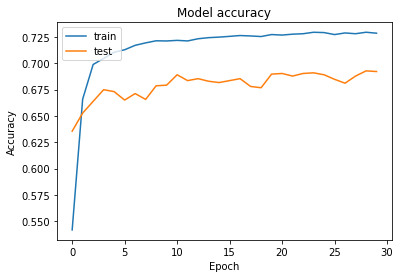

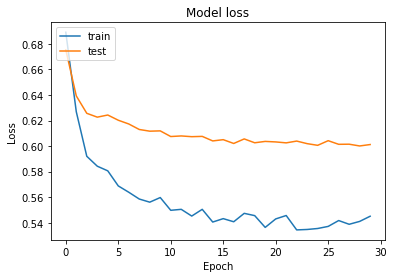

In [67]:
#collapse_hide
accuracy = results.history['win_output_accuracy']
val_accuracy = results.history['val_win_output_accuracy']
loss = results.history['win_output_loss']
val_loss = results.history['val_win_output_loss']
# summarize history for accuracy
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model predictions
The cross plots for point differential and win/loss are generally well-behaved. The loss and accuracy of the model differ significantly from results on the Kaggle leaderboard for this competition. For reference, anything below a loss of 0.5 would be considered fantastic and flipping a coin would give you a loss of about 0.69. We see a similar effect in the point spread prediction with a rather loose correlation of 0.46.

However, this model is optimized to train embeddings, not to predict tournament games. In fact, a model trained to predict winners and losers of regular season games would perform poorly on tournament data anyway. Only the best play in the tournament - different features matter and making predictions even harder). So the model predictions aren't very useful, but the question still remains: are the embeddings meaningful? A comparison of the embeddings to the aggregated data used in training show that embeddings are a richer representation of the regular season data.

Pearson coefficient:  0.46


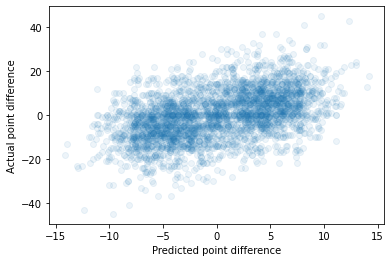

In [71]:
#collapse_hide
def transform_y(preds,stats_cache):
    preds = stats_cache['var'][1] * preds + stats_cache['mean'][1]
    return preds

preds = mymodel.predict(X_test)

x = transform_y(preds[1],stats_cache_train).reshape(-1)
y = transform_y(Y_norm_test[1],stats_cache_train).reshape(-1)


print('Pearson coefficient: ', round(stats.pearsonr(x, y)[0]*100)/100)
plt.scatter(x, y, alpha=0.08)
plt.xlabel('Predicted point difference')
plt.ylabel('Actual point difference')
plt.show()

Pearson coefficient:  1.0


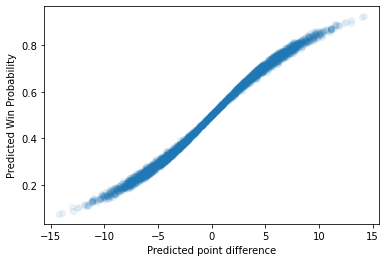

In [72]:
#collapse_hide
x = transform_y(preds[1],stats_cache_train).reshape(-1)
y = preds[0].reshape(-1)


print('Pearson coefficient: ', round(stats.pearsonr(x, y)[0]*100)/100)
plt.scatter(x, y, alpha=0.08)
plt.xlabel('Predicted point difference')
plt.ylabel('Predicted Win Probability')
plt.show()

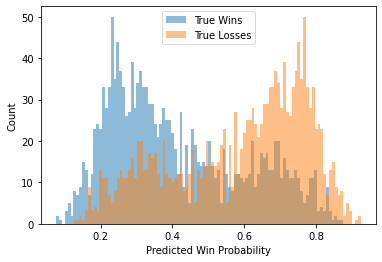

In [73]:
#collapse_hide
ywin = []
yloss = []
for ii in range(len(Y_test[0])):
    if Y_test[0,ii]==1:
        ywin += [y[ii]]
    else:
        yloss += [y[ii]]

plt.hist(yloss,bins=100, alpha=.5, label='True Wins')
plt.hist(ywin,bins=100, alpha=.5, label='True Losses')
plt.xlabel('Predicted Win Probability')
plt.ylabel('Count')
plt.legend(loc="upper center")
plt.show()

**As a brief aside:** One benefit of designing the network to predict pairwise-comparisons is its symmetry of predictions when the team order is swapped. Other ML models, such as XGBoost, treat the feature inputs of Team A and Team B differently, which can result in varying predictions when the teams are input in reverse order. This can be an issue even when training sets contain matchups and swapped matchups [as documented in this discussion](https://www.kaggle.com/c/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/discussion/130855).

## Exploratory analysis
Time to look at the embeddings:

In [74]:
#collapse_hide
embeddings = mymodel.layers[3].get_weights()[0]
pd.DataFrame(embeddings).head()

,0,1,2,3,4,5,6,7
0,0.035982,0.046932,-0.078709,-0.039354,-0.008067,0.124185,0.011310,0.034164
1,-0.016562,0.022565,-0.083342,0.018448,-0.029661,-0.040368,-0.016786,-0.010252
2,0.498684,-0.495477,0.499727,0.158760,0.240072,0.364154,0.203715,-0.369073
3,0.010758,-0.038044,0.081322,0.045811,0.037788,0.005300,-0.088485,-0.087438
4,0.322919,-0.237802,0.431424,0.164253,0.317093,0.254339,0.400500,-0.205829


That wasn't very helpful was it? The embeddings are 8 values per team. To visualize them we need to condense them down to a form that we can plot more easily. [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) is a non-linear mapping algorithm that can represent the vectors in 2D space. It tends to keep vectors that are similar in the embedding space clustered together in 2D space. In our case, t-SNE projects the embeddings into a warped space with the strongest teams tending toward one side and the weakest toward the other.

Let's take a look at some comparisons between our t-SNE embeddings with and the aggregated game statistics of each team. All of these plots (excluding the final plot for 2020) include only the NCAA tournament teams of a given year.

The plots below highlight a few different historical factors:
 - Tournament seed number
 - Number of NCAA Tournament games won that season
 - Tournament winners
 - Some of the biggest upsets (from these two articles -> [1](https://www.cbssports.com/college-basketball/news/march-madness-2019-the-10-biggest-upsets-ever-in-the-opening-weekend-of-the-tournament/), [2](https://fansided.com/2020/03/16/biggest-march-madness-upsets-ncaa-tournament/10/))
 - The tournament field by season
 - All data for all teams the 2020 regular season

 

In [75]:
#collapse_hide
t = TSNE(n_components=2,random_state=13)
embed_tsne = t.fit_transform(embeddings)

df_regSeason_full['T1_TeamName'] = df_regSeason_full['T1_TeamID'].apply(lambda x: teams_dict[x]) + '-' + df_regSeason_full['Season'].astype(str)
df_agg=df_regSeason_full.groupby('T1_TeamName').mean()
df_agg.reset_index(inplace=True,drop=False)

df_agg[['T1_TeamName','Win','Score_diff']]
df_agg.drop(columns='Season',inplace=True)

df_tourney_data = pd.read_csv(dataLoc/'MNCAATourneyCompactResults.csv')
df_tourney_data['WTeamName'] = df_tourney_data['WTeamID'].apply(lambda x: teams_dict[x]) + '-' + df_tourney_data['Season'].astype(str)
df_tourney_data['Wins'] = 0
df_wins = df_tourney_data[['WTeamName','Wins']].groupby('WTeamName').count()
tourneyWinners = [df_tourney_data.loc[df_tourney_data['Season']==s,'WTeamName'].values[-1] for s in df_tourney_data['Season'].unique()]

df_seeds = pd.read_csv(dataLoc/'MNCAATourneySeeds.csv')
df_seeds['TeamName'] = df_seeds['TeamID'].apply(lambda x: teams_dict[x]) + '-' + df_seeds['Season'].astype(str)
df_seeds['Seed'] = df_seeds['Seed'].str.extract(r'(\d+)')
df_seeds['WonTourney'] = df_seeds['TeamName'].apply(lambda x: True if x in tourneyWinners else False)
df_seeds = df_seeds[['TeamName','Seed','WonTourney']]

df_upsets = pd.read_csv('./data/2020-05-04-NCAA-Embeddings/Upsets.csv')
df_upsets['David']=df_upsets['David']+'-'+df_upsets['Season'].astype(str)
df_upsets['Goliath']=df_upsets['Goliath']+'-'+df_upsets['Season'].astype(str)
upsets = {}
for ii in df_upsets['David'].unique():
    upsets[ii] = 'Surprise'
for ii in df_upsets['Goliath'].unique():
    upsets[ii] = 'Bust'
df_seeds = pd.merge(left=df_seeds, right=df_wins, how='left', left_on='TeamName',right_index=True)
df_seeds['Wins'].fillna(0,inplace=True)

def upset(x):
    try:
        y = upsets[x]
    except:
        y = None
    return y
df_seeds['Upset'] = df_seeds['TeamName'].apply(lambda x: upset(x))

df = pd.DataFrame(embed_tsne,columns=['factor1','factor2'])
df['TeamName'] = [str(teams_dict[int(oh_to_id[x][-4:])]) + '-' + oh_to_id[x][:4] for x in df.index]
df['Season'] = [int(oh_to_id[x][:4])for x in df.index]

df = pd.merge(left=df, right=df_seeds, how='left', on='TeamName')
df = pd.merge(left=df, right=df_agg, how='left', left_on='TeamName',right_on='T1_TeamName')

df = df[['TeamName','Season','factor1','factor2','Win','Score_diff','Seed','Wins','Upset','WonTourney']]
df.columns = ['TeamName','Season','factor1','factor2','RegWins','RegPoint_diff','Seed','TourneyWins','Upset','WonTourney']

df2020 = df[df['Season']==2020].copy()

df.dropna(inplace=True,subset=['Seed'])

df['TourneyWinsScaled'] = df['TourneyWins']/df['TourneyWins'].max()
df['SeedScaled'] = df['Seed'].astype(int)/df['Seed'].astype(int).max()

**How correlated are the embeddings to tournament seeding?** 

In [91]:
#collapse_hide

axis_ranges = [[-60,100],
               [-80,80],
               [-10,30],
               [.2,1.2]]

def plot_comparison(df, colorBy, orderBy, axis_ranges):

    selector = alt.selection_single(empty='all', fields=['TeamName'])

    base = alt.Chart(df).mark_point(filled=True,size=50).encode(
        color=alt.condition(selector,
                            colorBy,
                            alt.value('lightgray') ),
        order=orderBy,
        tooltip=['TeamName','Seed']
    ).properties(
        width=250,
        height=250
    ).add_selection(selector).interactive()

    chart1 = [alt.X('factor1:Q',
                    scale=alt.Scale(domain=axis_ranges[0]),
                    axis=alt.Axis(title='t-SNE factor 1')),
            alt.Y('factor2:Q',
                    scale=alt.Scale(domain=axis_ranges[1]),
                    axis=alt.Axis(title='t-SNE factor 2'))]

    chart2 = [alt.X('RegPoint_diff:Q',
                    scale=alt.Scale(domain=axis_ranges[2]),
                    axis=alt.Axis(title='Average regular season point differential')),
            alt.Y('RegWins:Q',
                    scale=alt.Scale(domain=axis_ranges[3]),
                    axis=alt.Axis(format='%', title='Regular eason win percentage'))]

    return base, chart1, chart2

colorBy = alt.Color('Seed:Q', scale=alt.Scale(scheme='viridis',reverse=True))
orderBy = alt.Order('Seed:Q', sort='descending')
base, chart1, chart2 = plot_comparison( df,colorBy, orderBy, axis_ranges)

base.encode(*chart1)  | base.encode(*chart2)


alt.HConcatChart(...)

We see a high correlation between the assigned seed and our embeddings. Our embeddings appear to be a better representation of the seeding than the aggregated statistics, which makes sense since our method uses pair-wise comparisons and effectively accounts for team strength while aggregated statistics do not.

**Are features associated with tournament wins?**

In [84]:
#collapse_hide
colorBy = alt.Color('TourneyWins:Q', scale=alt.Scale(scheme='viridis',reverse=False))
orderBy = alt.Order('TourneyWins:Q', sort='ascending')
base, chart1, chart2 = plot_comparison( df,colorBy, orderBy, axis_ranges)

base.encode(*chart1)  | base.encode(*chart2)

alt.HConcatChart(...)

The embeddings appear to be far less correlated to the number of games won by tournament. This is logical since, unlike the seeds, this statistic is not at all represented in the training set.

**Are tournament winners differentiated?**

In [85]:
#collapse_hide
colorBy = alt.Color('WonTourney:N', scale=alt.Scale(scheme='tableau10'))
orderBy = alt.Order('WonTourney:N', sort='ascending')
base, chart1, chart2 = plot_comparison( df,colorBy, orderBy, axis_ranges)

base.encode(*chart1)  | base.encode(*chart2)

alt.HConcatChart(...)

One interesting insight below is how significantly different the 1985 Villanova team is from the other tournament winners. Multiple websites ([like this one](https://www.saturdayeveningpost.com/2018/05/10-biggest-underdogs-win-championship/)) list the 1985 Villanova team winning the championship as one of the greatest underdog stories ever. This is far more evident in the t-SNE representation of the embeddings than the plots of win percentage vs. points.

**Can we predict "the upsets"?**

In [86]:
#collapse_hide
colorBy = alt.Color('Upset:N', scale=alt.Scale(scheme='tableau10'))
orderBy = alt.Order('Upset:N', sort='ascending')
base, chart1, chart2 = plot_comparison( df,colorBy, orderBy, axis_ranges)

base.encode(*chart1)  | base.encode(*chart2)

alt.HConcatChart(...)

In short, no. These upsets are compiled from [here](https://www.cbssports.com/college-basketball/news/march-madness-2019-the-10-biggest-upsets-ever-in-the-opening-weekend-of-the-tournament/) and [here](https://fansided.com/2020/03/16/biggest-march-madness-upsets-ncaa-tournament/10/) - underdogs in red shown in red. Generally, the model agrees with the experts. These were upsets and wouldn't have been predicted by this method. If anything this method would likely have predicted *no upset* with even greater conviction tahn a model trained on just aggregated points and wins. The only exception to this is the 1986 "upset" of Cleveland State over the Indiana Hoosiers. Both the embeddings model and the aggregated statistics indicate that Cleveland State may have been the better team. Perhaps it was an issue of name recognition that lead this to be called an upset.

**How do these features change from year to year?** 

In [87]:
#collapse_hide
## create slider
select_year = alt.selection_single(
    name='select', fields=['Season'], init={'Season': 1985},
    bind=alt.binding_range(min=1985, max=2019, step=1))

colorBy = alt.Color('TourneyWins:Q', scale=alt.Scale(scheme='viridis',reverse=False))
orderBy = alt.Order('TourneyWins:Q', sort='ascending')
base, chart1, chart2 = plot_comparison( df,colorBy, orderBy, axis_ranges)
base = base.add_selection(select_year).transform_filter(select_year)

base.encode(*chart1)  | base.encode(*chart2)

alt.HConcatChart(...)

Since the plot is colored by games won, the tournament winner will appear as yellow. The spread of teams is quite variable year to year. Notably, the tournament that the 1985 Villanova team won as a heavy underdog has less spread in the competition than other years.

**What would the 2020 tournament have looked like?**

In [90]:
#collapse_hide
colorBy = alt.Color('TeamName:N')
axis_ranges = [[-80,90],[-80,70],[-30,30],[0,1]]
orderBy = alt.Order('Upset:N', sort='ascending')
base, chart1, chart2 = plot_comparison( df2020,colorBy, orderBy, axis_ranges)

base.encode(*chart1)  | base.encode(*chart2)

alt.HConcatChart(...)

## Conclusions
The embeddings appear to have learned which teams are better and which are worse. It seems that they are a better representation of team skill than simple aggregating the statistics used in model training (wins and point differentials). Using the flexibility of embeddings and Keras, the model could be easily generalized to more advanced statistics. I'll test this in a future post and would be surprised if this concept doesn't find its way into my 2021 NCAA Tournament models.

